# Summarization

## Use case

--- 

Suppose you have a set of documents (PDFs, Notion pages, customer questions, etc.) and you want to summarize the content. 

LLMs are a great tool for this given their proficiency in understanding and synthesizing text.

In this walkthrough we'll go over how to perform document summarization using LLMs.

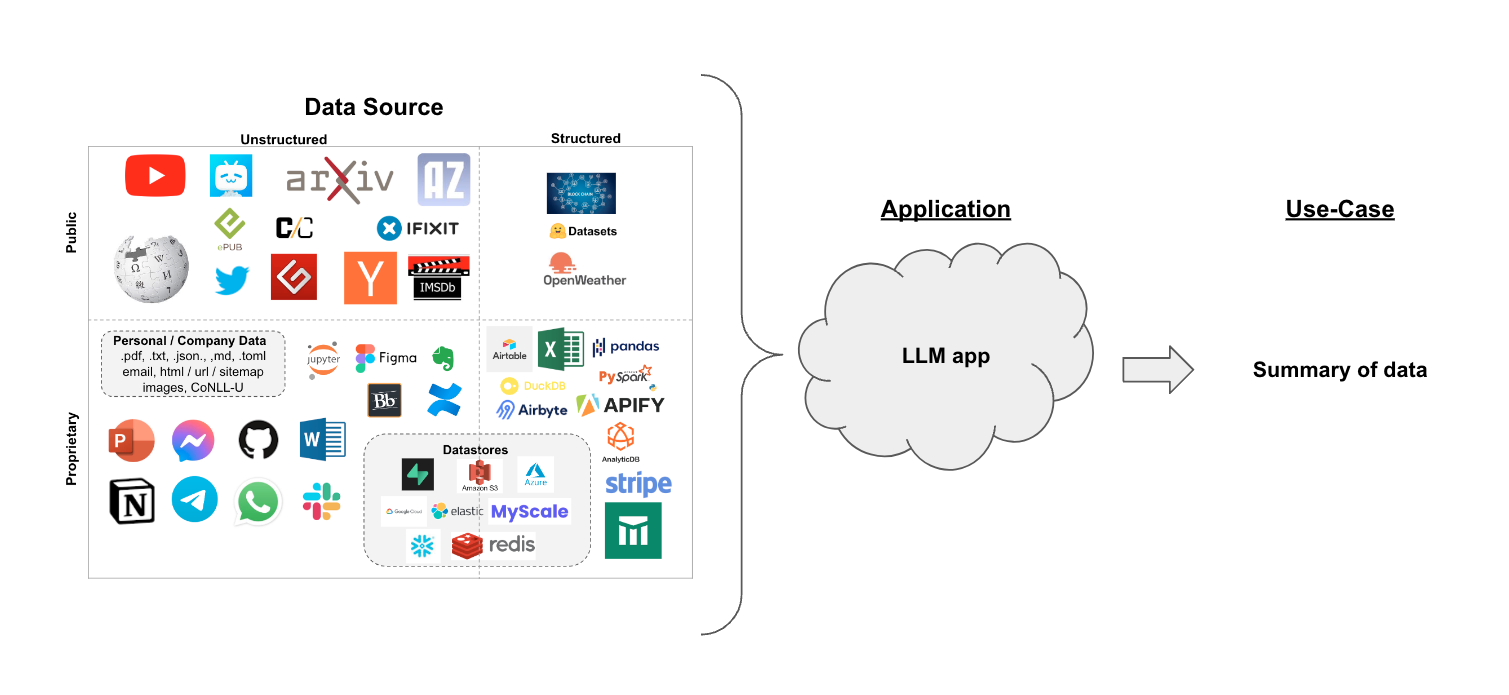

## Overview

--- 

A central question is whether the documents fit into the LLM context window. Two common approaches for are:

1. `Stuff`: This is the simplest form of the summarization that will attempt to fit all the documents into the prompt (see [here](https://langchain-fzn9vbdgo-langchain.vercel.app/docs/modules/chains/document/stuff)).

2. `Map reduce`: Summarize sub-sets in a "map" step and then "reduce" the summaries into a final summary (see [here](https://langchain-fzn9vbdgo-langchain.vercel.app/docs/modules/chains/document/map_reduce)).

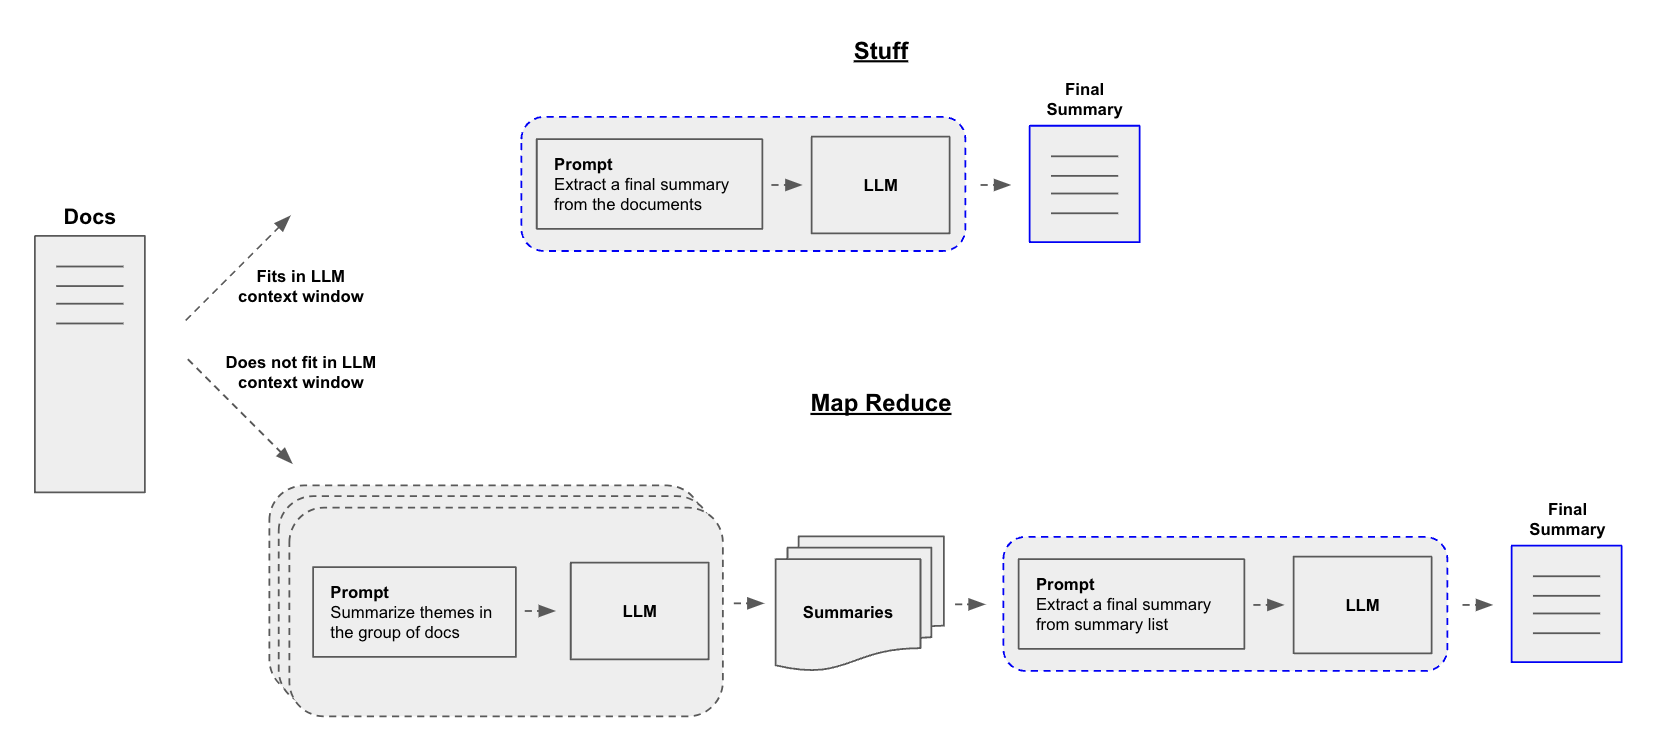

## Quickstart

--- 

To give you a sneak preview, either pipeline can be wrapped in a single object: `load_summarize_chain`. 

Suppose we want to summarize a blog post. We can create this in a few lines of code.

First set environment variables and install packages:

In [ ]:
pip install openai chromadb
export OPENAI_API_KEY="..."

Using larger context window models:

* 16k token OpenAI `gpt-3.5-turbo-16k` 
* 100k token Anthropic [Claude-2](https://www.anthropic.com/index/claude-2)

We can use `chain_type="stuff"` or `"map_reduce`:

In [3]:
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import WebBaseLoader
from langchain.chains.summarize import load_summarize_chain
llm=ChatOpenAI(temperature=0,model_name="gpt-3.5-turbo-16k")
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
chain = load_summarize_chain(llm, chain_type="stuff")
chain.run(loader.load())

'The article discusses the concept of building autonomous agents powered by large language models (LLMs). It explores the components of such agents, including planning, memory, and tool use. The article provides case studies and proof-of-concept examples of LLM-powered agents in various domains. It also highlights the challenges and limitations of using LLMs in agent systems.'

## Option 1. Stuff

--- 

When we use `load_summarize_chain` with `chain_type="stuff"`, we will use the [StuffDocumentsChain](https://python.langchain.com/docs/modules/chains/document/stuff).

The chain will take a list of documents, inserts them all into a prompt, and passes that prompt to an LLM:

In [8]:
from langchain.chains.llm import LLMChain
from langchain.prompts import PromptTemplate
from langchain.chains.combine_documents.stuff import StuffDocumentsChain

# Define prompt
prompt_template = """Write a concise summary of the following:
"{text}"
CONCISE SUMMARY:"""
PROMPT = PromptTemplate(template=prompt_template, input_variables=["text"])

# Define LLM chain
document_variable_name="text"
llm=ChatOpenAI(temperature=0,model_name="gpt-3.5-turbo-16k")
llm_chain = LLMChain(llm=llm, prompt=PROMPT)

# Define StuffDocumentsChain
stuff_chain = StuffDocumentsChain(
    llm_chain=llm_chain,
    document_variable_name=document_variable_name)

input_doc = loader.load()
stuff_chain.run(input_doc)

'The article discusses the concept of building autonomous agents powered by large language models (LLMs). It explores the components of such agents, including planning, memory, and tool use. The article provides case studies and examples of proof-of-concept demos, highlighting the challenges and limitations of LLM-powered agents. It also includes references to related research papers and provides a citation for the article.'

Great! We can see that we reproduce the earlier result using the `load_summarize_chain`.

### Go deeper

* You can easily customize the prompt. 
* You can easily try different LLMs, (e.g., [Claude](https://python.langchain.com/docs/integrations/chat/anthropic)) via the `llm` parameter.

## Option 2. Map Reduce

---

Let's unpack the map reduce chain.
 
First, we specfy a few things:

* LLM, prompt, and text splitter for map stage
* LLM and prompt for reduce stage

In [17]:
from langchain.chains.mapreduce import MapReduceChain
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains import ReduceDocumentsChain, MapReduceDocumentsChain

# Map 
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(chunk_size=4000,chunk_overlap=0)
map_template_string = """The following is set of documents
{docs}
Based on this list docs, please identify the main themes 
Helpful Answer:"""
MAP_PROMPT = PromptTemplate(input_variables=["docs"], template=map_template_string)
map_llm_chain = LLMChain(llm=ChatOpenAI(temperature=0), prompt=MAP_PROMPT)

# Reduce
reduce_template_string = template = """The following is set of summaries:
{doc_summaries}
Take these and distill it into a final, consolidated summary of the main themes. 
Helpful Answer:"""
REDUCE_PROMPT = PromptTemplate(input_variables=["doc_summaries"], template=reduce_template_string)
reduce_llm_chain = LLMChain(llm=ChatOpenAI(temperature=0), prompt=REDUCE_PROMPT)

Now, we specify each part of the map-reduce chain.

`Reduce`

* `StuffDocumentsChain`: Pack all the summaries from map into the prompt of `reduce_llm_chain`
* `ReduceDocumentsChain`: Handle cases where the summaries exceed the context window of `reduce_llm_chain`

In [18]:
# Takes a list of documents and combines them into a single string
combine_documents_chain = StuffDocumentsChain(
        llm_chain=reduce_llm_chain,
        document_variable_name="doc_summaries")
    
# Combines and iteravely reduces the mapped documents 
reduce_documents_chain = ReduceDocumentsChain(
    # This is final chain that is called.
    combine_documents_chain=combine_documents_chain,
    # If documents exceed context for `StuffDocumentsChain`
    collapse_documents_chain=combine_documents_chain,
    # The maximum number of tokens to group documents into.
    token_max=4000)

`Map`

* `MapReduceChain`: Apply `text_splitter` to input of `MapReduceDocumentsChain`
* `MapReduceDocumentsChain`: Apply `map_llm_chain` on `text_splitter` output, then `reduce_documents_chain` 

In [19]:
# Combining documents by mapping a chain over them, then combining results
combine_documents = MapReduceDocumentsChain(
    # Map chain
    llm_chain=map_llm_chain,
    # Reduce chain
    reduce_documents_chain=reduce_documents_chain,
    # The variable name in the llm_chain to put the documents in
    document_variable_name="docs",
    # Return the results of the map steps in the output
    return_intermediate_steps=Falsea)
        
map_reduce = MapReduceChain(
    # Chain to combine documents
    combine_documents_chain=combine_documents,
    # Splitter to use for initial split
    text_splitter=text_splitter)

In [24]:
map_reduce.run(input_text=input_doc[0].page_content)

"The main themes identified in the provided set of documents revolve around the concept of LLM-powered autonomous agents. These agents utilize large language models as their core controllers and have the potential to generate well-written copies, stories, essays, and programs. The documents discuss the key components of such agent systems, including planning, memory, and tool use, and highlight their roles in enhancing the agent's capabilities. Task decomposition techniques, self-reflection frameworks, and memory enhancement techniques are explored. Additionally, the documents touch upon the challenges and limitations associated with finite context length, long-term planning, and the reliability of natural language interfaces. Overall, the main themes encompass LLM-powered autonomous agents, their components, and the techniques used to enhance their planning, memory, and tool use capabilities."

### Go deeper
 
**Customization** 

* As shown above, you can customize the LLMs and prompts for map and reduce stages.

**Real-world use-case**

* See [this blog post](https://blog.langchain.dev/llms-to-improve-documentation/) case-study on analyzing user interactions (questions about LangChain documentation)!  

## Option 3. Refine

--- 
 
[Refine](https://langchain-fzn9vbdgo-langchain.vercel.app/docs/modules/chains/document/refine) is similar to map-reduce:

> The refine documents chain constructs a response by looping over the input documents and iteratively updating its answer. For each document, it passes all non-document inputs, the current document, and the latest intermediate answer to an LLM chain to get a new answer.

This can be easily run with the `chain_type="refine"` specified.

In [37]:
chain = load_summarize_chain(llm, chain_type="refine")
chain.run(input_doc)

'The article discusses the concept of building autonomous agents powered by large language models (LLMs). It explores the components of such agents, including planning, memory, and tool use. The article provides case studies and proof-of-concept examples of LLM-powered agents in various domains. It also highlights the challenges and limitations of using LLMs in agent systems.'

In [39]:
prompt_template = """Write a concise summary of the following:
{text}
CONCISE SUMMARY:"""
PROMPT = PromptTemplate(template=prompt_template, input_variables=["text"])

refine_template = (
    "Your job is to produce a final summary\n"
    "We have provided an existing summary up to a certain point: {existing_answer}\n"
    "We have the opportunity to refine the existing summary"
    "(only if needed) with some more context below.\n"
    "------------\n"
    "{text}\n"
    "------------\n"
    "Given the new context, refine the original summary in Italian"
    "If the context isn't useful, return the original summary."
)
refine_prompt = PromptTemplate(
    input_variables=["existing_answer", "text"],
    template=refine_template,
)
chain = load_summarize_chain(llm=llm, chain_type="refine", return_intermediate_steps=True, question_prompt=PROMPT, refine_prompt=refine_prompt)
chain({"input_documents": input_doc}, return_only_outputs=True)

{'intermediate_steps': ['The article discusses the concept of building autonomous agents powered by large language models (LLMs). It explores the components of such agents, including planning, memory, and tool use. The article provides case studies and examples of proof-of-concept demos, highlighting the challenges and limitations of LLM-powered agents. It also includes references to related research papers and benchmarks.'],
 'output_text': 'The article discusses the concept of building autonomous agents powered by large language models (LLMs). It explores the components of such agents, including planning, memory, and tool use. The article provides case studies and examples of proof-of-concept demos, highlighting the challenges and limitations of LLM-powered agents. It also includes references to related research papers and benchmarks.'}